<a href="https://colab.research.google.com/github/rickqiu/deep-learning/blob/master/PyTorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Tutorial: How to Develop Deep Learning Models with Python

Jason Brownlee (2020) in Deep Learning
https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

In [1]:
# check pytorch version
import torch
print(torch.__version__)

1.8.1+cu101


The five steps in the life-cycle are as follows:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Make Predictions.


The training process requires that you define a loss function and an optimization algorithm.

Common loss functions include the following:

BCELoss: Binary cross-entropy loss for binary classification.
CrossEntropyLoss: Categorical cross-entropy loss for multi-class classification.
MSELoss: Mean squared loss for regression.~

## 1. How to Develop an MLP for Binary Classification

We will use the Ionosphere binary (two class) classification dataset to demonstrate an MLP for binary classification.

This dataset involves predicting whether there is a structure in the atmosphere or not given radar returns.

The dataset will be downloaded automatically using Pandas, but you can learn more about it here.

[Ionosphere Dataset (csv)]( https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv).

[Ionosphere Dataset Description](https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.names).

In [3]:
# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self,[train_size, test_size])

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

# prepare the data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(34)
# train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)
# make a single prediction (expect class=1)
row = [1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300]
yhat = predict(row, model)
print('Predicted: %.3f (class=%d)' % (yhat, yhat.round()))

235 116
Accuracy: 0.879
Predicted: 0.995 (class=1)


## 2.  How to Develop an MLP for Multiclass Classification

We will use the Iris flowers multiclass classification dataset to demonstrate an MLP for multiclass classification.

This problem involves predicting the species of iris flower given measures of the flower.

The dataset will be downloaded automatically using Pandas, but you can learn more about it here.

[Iris Dataset (csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv).

[Iris Dataset Description](https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.names).

In [71]:
# pytorch mlp for multiclass classification
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear, Dropout, ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('int64')
        

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 5)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(5, 3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        X = self.hidden3(X)
        X = self.act3(X)
        return X

# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=8, shuffle=True, drop_last=True)
    test_dl = DataLoader(test, batch_size=8, shuffle=False, drop_last=True)
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.001)

    # enumerate epochs
    for epoch in range(500):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

# prepare the data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(4)
# train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)
# make a single prediction
row = [5.1,3.5,1.4,0.2]
yhat = predict(row, model)
print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

100 50
Accuracy: 0.938
Predicted: [[9.9988079e-01 1.1924102e-04 3.5363959e-19]] (class=0)


## 3. How to Develop an MLP for Regression

We will use the Boston housing regression dataset to demonstrate an MLP for regression predictive modeling.

This problem involves predicting house value based on properties of the house and neighborhood.

The dataset will be downloaded automatically using Pandas, but you can learn more about it here.

[Boston Housing Dataset (csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv).

[Boston Housing Dataset Description](https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.names).

In [72]:
# pytorch mlp for regression
from numpy import vstack
from numpy import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_

# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1].astype('float32')
        self.y = df.values[:, -1].astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X

# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

# prepare the data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(13)
# train the model
train_model(train_dl, model)
# evaluate the model
mse = evaluate_model(test_dl, model)
print('MSE: %.3f, RMSE: %.3f' % (mse, sqrt(mse)))
# make a single prediction (expect class=1)
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
yhat = predict(row, model)
print('Predicted: %.3f' % yhat)

339 167
MSE: 79.054, RMSE: 8.891
Predicted: 22.452


## 4. How to Develop a CNN for Image Classification

Convolutional Neural Networks, or CNNs for short, are a type of network designed for image input.

They are comprised of models with convolutional layers that extract features (called feature maps) and pooling layers that distill features down to the most salient elements.

The torchvision API provides a convenience function to download and load this dataset directly.

The example below loads the dataset and plots the first few images.

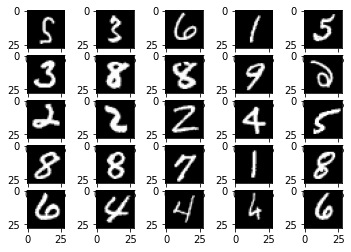

In [74]:
# load mnist dataset in pytorch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from matplotlib import pyplot
# define location to save or load the dataset
path = '~/.torch/datasets/mnist'
# define the transforms to apply to the data
trans = Compose([ToTensor()])
# download and define the datasets
train = MNIST(path, train=True, download=True, transform=trans)
test = MNIST(path, train=False, download=True, transform=trans)
# define how to enumerate the datasets
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)
# get one batch of images
i, (inputs, targets) = next(enumerate(train_dl))
# plot some images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(inputs[i][0], cmap='gray')
# show the figure
pyplot.show()

In [76]:
# pytorch cnn for multiclass classification
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# model definition
class CNN(Module):
    # define model elements
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        # fully connected layer
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # flatten
        X = X.view(-1, 5*5*32)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X

# prepare the dataset
def prepare_data(path):
    # define standardization
    trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # load dataset
    train = MNIST(path, train=True, download=True, transform=trans)
    test = MNIST(path, train=False, download=True, transform=trans)
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=256, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

# prepare the data
path = '~/.torch/datasets/mnist'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = CNN(1)
# # train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

60000 10000
Accuracy: 0.795


In [89]:
from torchsummary import summary
if torch.cuda.is_available():
    model.cuda()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           9,248
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Linear-7                  [-1, 100]          80,100
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
          Softmax-10                   [-1, 10]               0
Total params: 90,678
Trainable params: 90,678
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.35
Estimated Tot